In [3]:
# %pip install easyocr 
# %pip install imutils 
# %pip install opencv-python 
# %pip install matplotlib

In [4]:
import cv2 
from matplotlib import pyplot as plt
import numpy as np
import easyocr
import imutils
import random

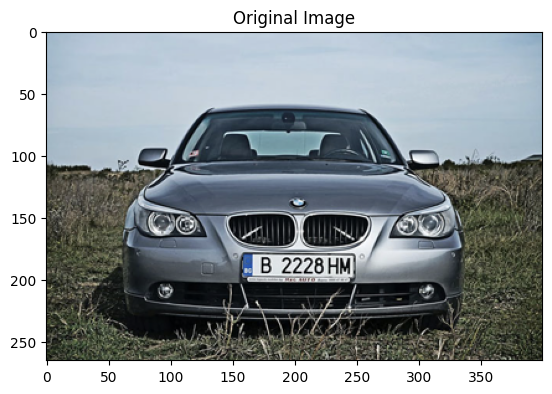

Text(0.5, 1.0, 'Processed Image')

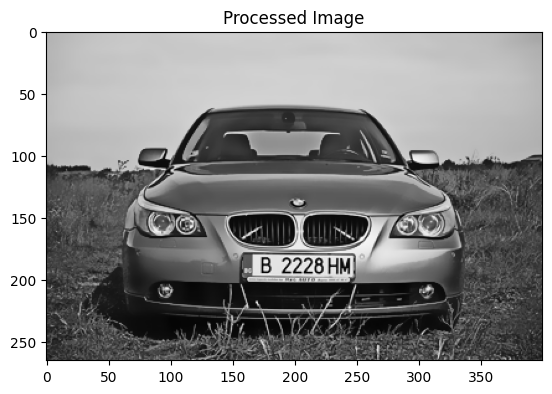

In [ ]:
ruta = "C:/Users/delahozce/OneDrive - GLOBAL HITSS/Documentos/Proyectos/Codes/git_portafolio/Portafolio/data/imagenes_carros/"
img = cv2.imread(ruta + "Cars120.png") #read image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.show()

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert image to gray
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
plt.imshow(cv2.cvtColor(bfilter, cv2.COLOR_BGR2RGB)) #show processed image
plt.title('Processed Image')

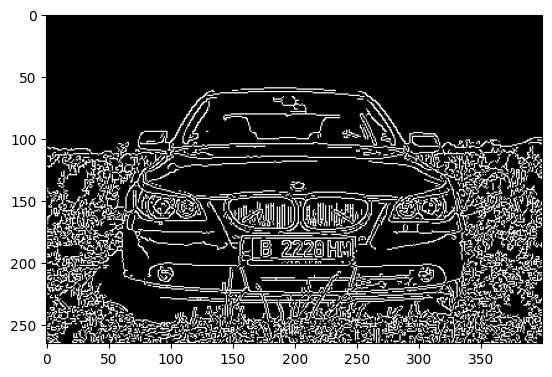

In [14]:
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

In [15]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) #Find contours 
contours = imutils.grab_contours(keypoints) #Grab contours 
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10] #Sort contours

In [16]:
#Loop over our contours to find the best possible approximate contour of 10 contours
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break
     
print("Location: ", location)

Location:  [[[207 166]]

 [[213 148]]

 [[259 153]]

 [[246 171]]]


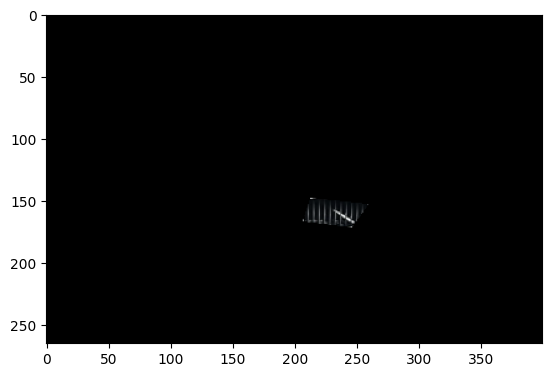

In [17]:
mask = np.zeros(gray.shape, np.uint8) #create blank image with same dimensions as the original image
new_image = cv2.drawContours(mask, [location], 0,255, -1) #Draw contours on the mask image
new_image = cv2.bitwise_and(img, img, mask=mask) #Take bitwise AND between the original image and mask image

plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)) #show the final image

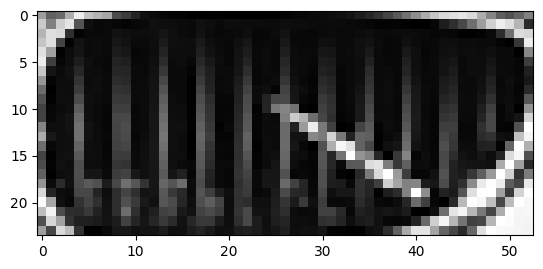

In [18]:
(x,y) = np.where(mask==255) #Find the co-ordinates of the four corners of the document
(x1, y1) = (np.min(x), np.min(y)) #Find the top left corner
(x2, y2) = (np.max(x), np.max(y)) #Find the bottom right corner
cropped_image = gray[x1:x2+1, y1:y2+1] #Crop the image using the co-ordinates

plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)) #show the cropped image

In [19]:
reader = easyocr.Reader(['en']) #create an easyocr reader object with english as the language
result = reader.readtext(cropped_image) #read text from the cropped image
result

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

[]

In [20]:
text = result[0][-2] #Extract the text from the result
font = cv2.FONT_HERSHEY_SIMPLEX #Font style
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA) #put the text on the image
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3) #Draw a rectangle around the text

plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB)) #show the final image with text

IndexError: list index out of range

In [38]:
imag1 = ruta + "Test1.jpg"
imag2 = ruta + "Cars120.png"

In [59]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import easyocr

def detect_plate(ruta, filename):
    # Leer imagen
    img = cv2.imread(ruta + filename)
    if img is None:
        raise Exception("No se pudo cargar la imagen")
    
    # Guardar copia original
    original = img.copy()
    
    # Mostrar imagen original
    plt.figure(figsize=(10,6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Imagen Original')
    plt.axis('off')
    plt.show()

    # Convertir a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Mejorar contraste
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    
    # Suavizado y reducción de ruido
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Detección de bordes
    edged = cv2.Canny(blurred, 50, 200)
    
    # Dilatación para conectar componentes
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    edged = cv2.dilate(edged, kernel, iterations=1)
    
    # Mostrar bordes
    plt.figure(figsize=(10,6))
    plt.imshow(edged, cmap='gray')
    plt.title('Detección de Bordes')
    plt.axis('off')
    plt.show()

    # Encontrar contornos
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    
    # Imagen para visualización de contornos
    contour_img = original.copy()
    
    # Filtrar contornos
    candidates = []
    for contour in contours:
        # Obtener rectángulo rotado
        rect = cv2.minAreaRect(contour)
        (_, (width, height), angle) = rect
        
        # Calcular área y relación de aspecto
        area = width * height
        aspect_ratio = max(width, height) / min(width, height)
        
        # Filtros específicos para placas
        if area > 1000 and 2.0 < aspect_ratio < 5.5:
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            candidates.append(box)
            # Dibujar candidatos en verde claro
            cv2.drawContours(contour_img, [box], 0, (0, 255, 0), 2)
    
    # Mostrar todos los candidatos
    plt.figure(figsize=(10,6))
    plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
    plt.title('Candidatos de Placa')
    plt.axis('off')
    plt.show()
    
    if not candidates:
        raise Exception("No se detectaron candidatos de placa")
    
    # Seleccionar el mejor candidato basado en características de la placa
    best_plate = None
    max_score = 0
    
    for candidate in candidates:
        rect = cv2.minAreaRect(candidate)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        
        # Crear máscara para la región
        mask = np.zeros(gray.shape, np.uint8)
        cv2.drawContours(mask, [box], 0, 255, -1)
        
        # Extraer región
        plate_region = cv2.bitwise_and(gray, gray, mask=mask)
        
        # Calcular características
        mean_intensity = cv2.mean(gray, mask=mask)[0]
        std_dev = cv2.meanStdDev(gray, mask=mask)[1][0][0]
        
        # Puntuación basada en características típicas de placas
        score = std_dev * (1 + abs(mean_intensity - 127)/127)
        
        if score > max_score:
            max_score = score
            best_plate = box
    
    if best_plate is None:
        raise Exception("No se pudo identificar la placa")
    
    # Dibujar resultado final
    result = original.copy()
    cv2.drawContours(result, [best_plate], -1, (0, 255, 0), 3)
    
    # Extraer región de la placa para OCR
    rect = cv2.minAreaRect(best_plate)
    width = int(rect[1][0])
    height = int(rect[1][1])
    
    src_pts = best_plate.astype("float32")
    dst_pts = np.array([[0, height-1],
                       [0, 0],
                       [width-1, 0],
                       [width-1, height-1]], dtype="float32")
    
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped = cv2.warpPerspective(gray, M, (width, height))
    
    if width < height:
        warped = cv2.rotate(warped, cv2.ROTATE_90_CLOCKWISE)
    
    # Preprocesar para OCR
    plate_img = cv2.resize(warped, None, fx=2, fy=2)
    _, plate_img = cv2.threshold(plate_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Mostrar placa procesada
    plt.figure(figsize=(10,6))
    plt.imshow(plate_img, cmap='gray')
    plt.title('Placa Procesada')
    plt.axis('off')
    plt.show()
    
    # OCR
    reader = easyocr.Reader(['en'])
    result = reader.readtext(
        plate_img,
        allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789',
        paragraph=False,
        height_ths=2.0,
        width_ths=2.0
    )
    
    if not result:
        raise Exception("No se pudo leer el texto de la placa")
    
    # Procesar texto
    text = result[0][-2]
    text = text.replace('0', 'O')
    if text[0] == '0':
        text = 'H' + text[1:]
    
    # Mostrar resultado final
    plt.figure(figsize=(10,6))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title(f'Resultado Final - Placa: {text}')
    plt.axis('off')
    plt.show()
    
    return text, result

def process_image(ruta, filename):
    try:
        text, result_image = detect_plate(ruta, filename)
        print(f"Placa detectada: {text}")
        return text, result_image
    except Exception as e:
        print(f"Error: {str(e)}")
        return None, None

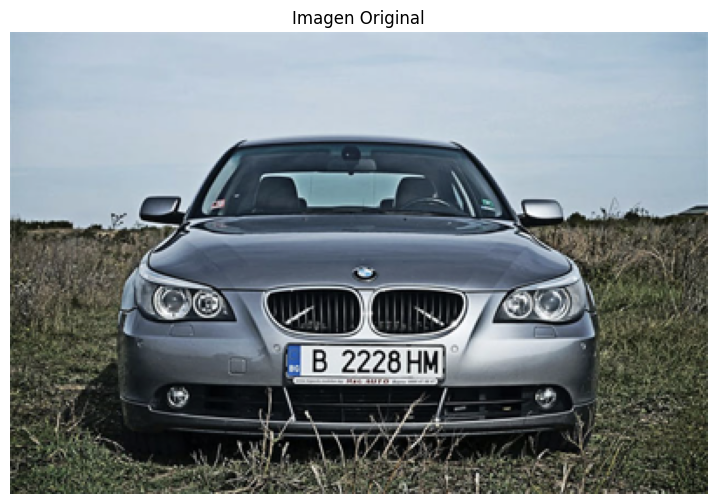

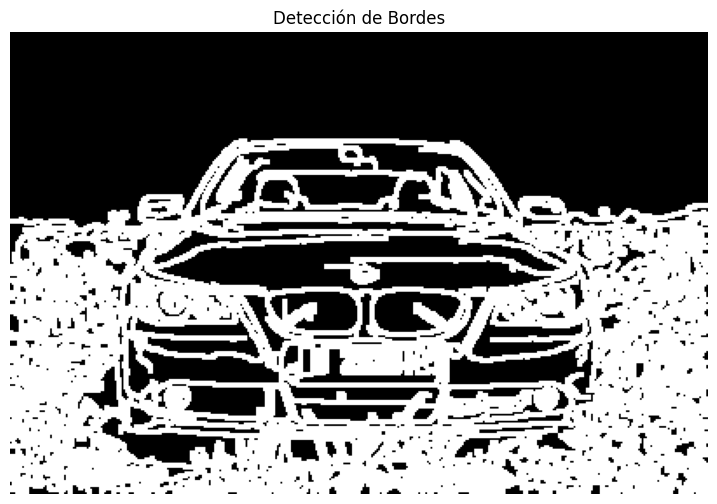

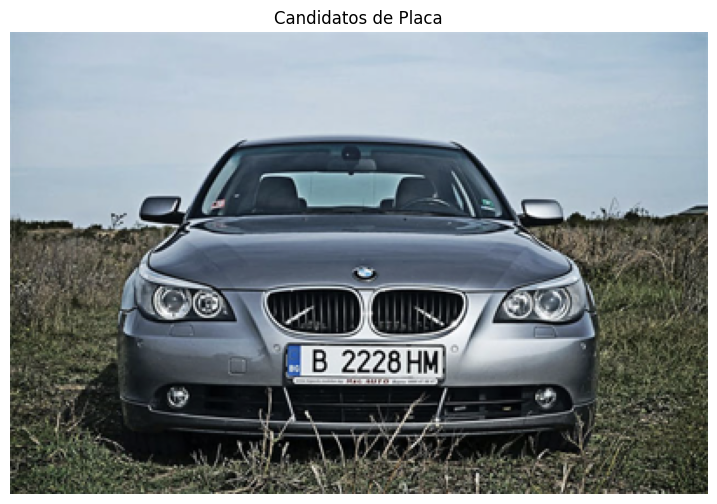

Error: No se detectaron candidatos de placa


In [60]:
ruta = "C:/Users/delahozce/OneDrive - GLOBAL HITSS/Documentos/Proyectos/Codes/git_portafolio/Portafolio/data/imagenes_carros/"
# Procesar una imagen
text, result_image = process_image(ruta, "Cars120.png")